In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import nibabel as nib
from nilearn import image, datasets
import ants

import matplotlib.pyplot as plt

In [2]:
## Create derivatives folder
input_dir = '../data/bids'
output_dir = '../data/derivatives'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


subject = 1
target_shape = (3,3,3)

## For anatomical files, align to MNI space

mni_img = ants.image_read(datasets.fetch_icbm152_2009()['t1'])
# mni_img_resampled = ants.resample_image(mni_img, target_shape)
# print(mni_img_resampled)
# plt.imshow(mni_img_resampled.numpy()[:,:,30])
# plt.show()

anat_img = ants.image_read(f"{input_dir}/sub-0{subject}/ses-01/anat/sub-0{subject}_ses-01_T1w.nii.gz")
# anat_img_resampled = ants.resample_image(anat_img, target_shape)

anat_reg = ants.registration(mni_img, anat_img, type_of_transform="SyN")


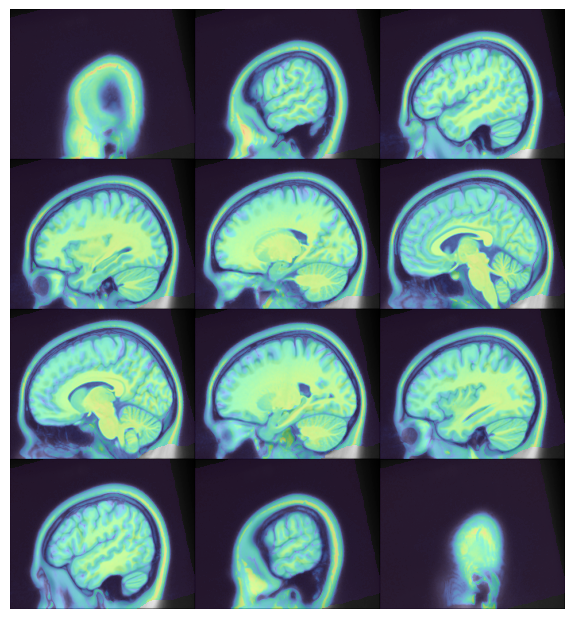

In [3]:

ants.plot(mni_img, overlay=anat_reg['warpedmovout'], overlay_alpha=0.5, crop=False)



In [4]:

## For functional files, align to anatomical file

fmri_path = f"{input_dir}/sub-0{subject}/ses-01/func/sub-0{subject}_ses-01_task-video_run-1_bold.nii.gz"

fmri = ants.image_read(fmri_path)

images_unmerged = ants.ndimage_to_list( fmri )



In [5]:
target_img = ants.crop_image(ants.resample_image(mni_img, target_shape))

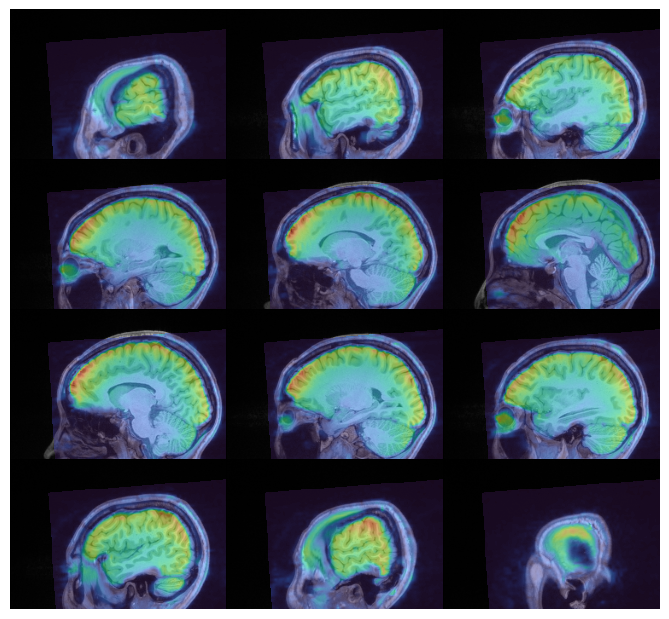

In [6]:


# plt.imshow(anat_img.numpy()[:,:,80])
# plt.show()
# plt.imshow(anat_reg['warpedmovout'].numpy()[:,:,80])
# plt.show()

# fmri_0 = ants.pad_image(images_unmerged[0], pad_width=[20,20,20])
# plt.imshow(fmri_0.numpy()[:,:,25])
# plt.show()

# anat_img_resampled = ants.resample_image_to_target(anat_img, images_unmerged[0])



# plt.imshow(anat_img_resampled.numpy()[:,:,25])
# plt.show()


fmri_reg = ants.registration(anat_img, images_unmerged[0], type_of_transform="BOLDAffine")

ants.plot(anat_img, overlay=fmri_reg['warpedmovout'], overlay_alpha=0.5, crop=False)


# mywarpedimage = ants.apply_transforms( fixed = target_img, 
#                                        moving = images_unmerged[0] , 
#                                        transformlist = fmri_reg['fwdtransforms'] + anat_reg['fwdtransforms'], 
#                                        interpolator  = 'nearestNeighbor'
# )


# ants.plot(mni_img, overlay=mywarpedimage, overlay_alpha=0.5, crop=False)



# plt.imshow(fmri_reg['warpedmovout'].numpy()[:,:,25])
# plt.show()

# fmri_cropped = ants.crop_image(fmri_reg['warpedmovout'])
# plt.imshow(fmri_cropped.numpy()[:,:,25])
# plt.show()

# print(fmri_cropped.shape)

# fmri_2 = ants.registration(fmri_cropped, images_unmerged[1], type_of_transform="Similarity")
# plt.imshow(fmri_2['warpedmovout'].numpy()[:,:,25])
# plt.show()

# ants.plot(anat_reg['warpedmovout'], overlay=fmri_2['warpedmovout'], overlay_alpha=0.5, crop=False)


In [7]:
# target_img = ants.crop_image(mni_img_resampled)

motion_corrected = list()

transforms = fmri_reg['fwdtransforms'] + anat_reg['fwdtransforms']


for i in tqdm(range(50)):
    aligned = ants.registration( images_unmerged[0], images_unmerged[i], "BOLDAffine" )
    areg = ants.apply_transforms(fixed = target_img, 
                                        moving = aligned['warpedmovout'] , 
                                        transformlist = transforms, 
                                        interpolator  = 'nearestNeighbor')
    motion_corrected.append( areg)



100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


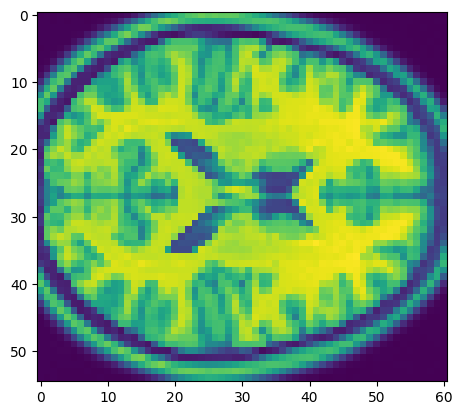

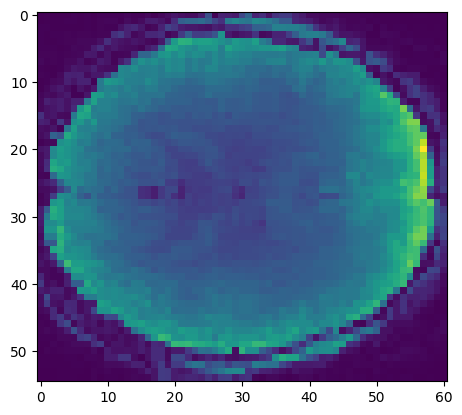

In [8]:
plt.imshow(target_img.numpy()[:,:,30])
plt.show()
plt.imshow(motion_corrected[0].numpy()[:,:,30])

In [17]:
print(target_img)
print(fmri)
# dummy_img = ants.make_image((55,61,54,1025), spacing=(3,3,3, 0.867), origin=(80,104,-72, 0), direction=[[-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
# dummy_img = ants.list_to_ndimage(target_img, [target_img, target_img])

# fmri_mc = ants.merge_channels(motion_corrected)
# Get the shape of the 3D images (assuming all images have the same shape)
image_shape = motion_corrected[0].shape

# Create a 4D NumPy array to hold the 3D images
# The shape will be (x, y, z, t) where t is the number of 3D images
num_images = len(motion_corrected)
four_d_array = np.zeros((image_shape[0], image_shape[1], image_shape[2], num_images))

# Populate the 4D array with the 3D images
for i, img in enumerate(motion_corrected):
    four_d_array[:, :, :, i] = img.numpy()

# Convert the 4D NumPy array back to an ANTs image
# Here we need to specify origin, spacing, and direction for 4 dimensions
origin_4d = list(motion_corrected[0].origin) + [0.0]
spacing_4d = list(motion_corrected[0].spacing) + [1.0]  # Assuming a temporal spacing of 1
direction_3d = motion_corrected[0].direction
direction_4d = np.eye(4)
direction_4d[:3, :3] = direction_3d

fmri_mc = ants.from_numpy(four_d_array, origin=origin_4d, spacing=spacing_4d, direction=direction_4d)

print(fmri_mc)
# # plt.imshow(fmri_mc.numpy()[:,:,30,0])
ants.image_write(fmri_mc, 'test_img.nii.gz')

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (55, 61, 54)
	 Spacing    : (3.0, 3.0, 3.0)
	 Origin     : (80.0, 104.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (74, 74, 51, 1025)
	 Spacing    : (2.973, 2.973, 3.0, 0.867)
	 Origin     : (-109.0044, 112.9949, -48.583, 0.0)
	 Direction  : [ 0.9984 -0.0478 -0.0306  0.     -0.0509 -0.9926 -0.1106  0.      0.0251
 -0.112   0.9934  0.      0.      0.      0.      1.    ]

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (55, 61, 54, 50)
	 Spacing    : (3.0, 3.0, 3.0, 1.0)
	 Origin     : (80.0, 104.0, -72.0, 0.0)
	 Direction  : [-1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]



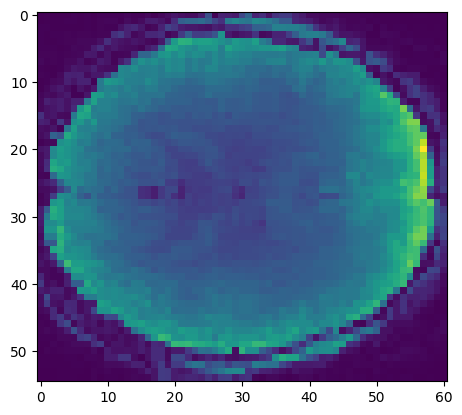

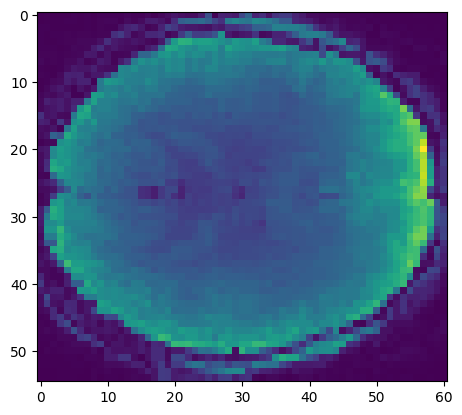

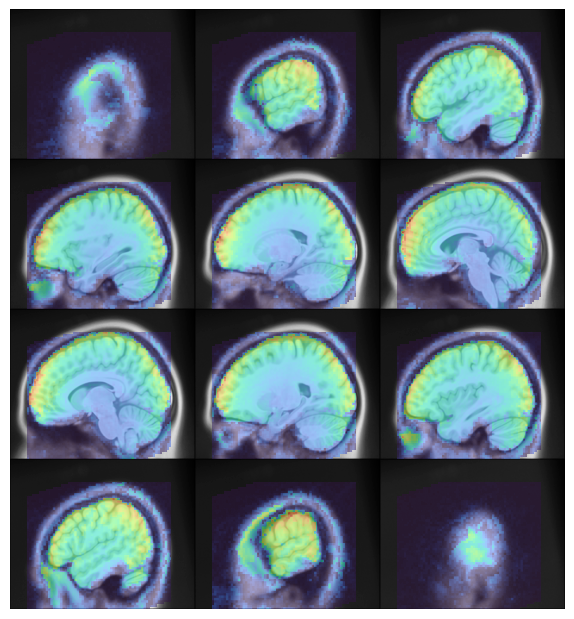

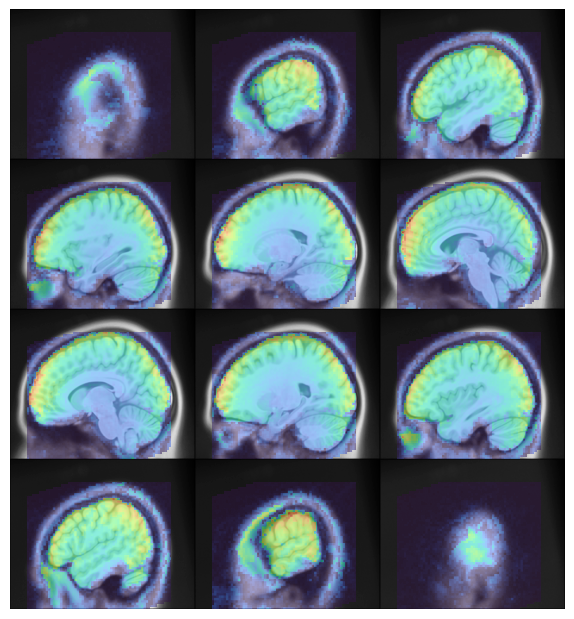

In [18]:
import nibabel as nib

img = nib.load('test_img.nii.gz')
plt.imshow(img.slicer[...,0].get_fdata()[:,:,30])
plt.show()

img_ants = ants.image_read('test_img.nii.gz')
plt.imshow(img_ants.numpy()[:,:,30,0])
plt.show()

ants.plot(mni_img, overlay=motion_corrected[0], overlay_alpha=0.5, crop=False)
ants.plot(mni_img, overlay=ants.ndimage_to_list(img_ants)[0], overlay_alpha=0.5, crop=False)

In [27]:


# mc_path = f"{output_dir}/sub-0{subject}/ses-01/func/sub-0{subject}_ses-01_task-video_run-1_motion-corrected_bold.nii.gz"
# path, name = os.path.split(mc_path)
# if not os.path.exists(path):
#     os.makedirs(path)

# ants.image_write( fmri_mc, mc_path )

In [19]:
import numpy as np
import json

In [20]:
fmri_np = fmri_mc.numpy()

# Get slice timing info
json_path = f"{input_dir}/sub-0{subject}/ses-01/func/sub-0{subject}_ses-01_task-video_run-1_bold.json"

with open(json_path) as json_file:
    metadata = json.load(json_file)



In [24]:

slice_timing = metadata["SliceTiming"]
print(len(slice_timing))

tr = metadata['RepetitionTime']
print(tr)

align_time = tr / 2



51
0.867


In [22]:
def linear_interpolation(value1, value2, time1, time2, target_time):
    return value1 + (value2 - value1) * ((target_time - time1) / (time2 - time1))

fmri_st = np.copy(fmri_np)

print(fmri_np.shape)
# For every frame, iterate through slices
for i in tqdm(range(1, fmri_np.shape[3] - 1)):

    for j in range(fmri_np.shape[2]):

        t = slice_timing[j]
            
        slice_t_minus_1 = fmri_np[..., j, i - 1]
        slice_t = fmri_np[..., j, i]
        slice_t_plus_1 = fmri_np[..., j, i + 1]
        
        if t < align_time:
            t1 = t
            t2 = t + tr
            val1 = slice_t
            val2 = slice_t_plus_1
        else:
            t1 = t - tr
            t2 = t
            val1 = slice_t_minus_1
            val2 = slice_t

        fmri_st[..., j, i] = linear_interpolation(val1, val2, t1, t2, align_time)




(55, 61, 54, 50)


  0%|          | 0/48 [00:00<?, ?it/s]


IndexError: list index out of range

In [62]:
import numpy as np
import json
from scipy.interpolate import splrep, splev

def slice_timing_correction(fmri_data, slice_times, tr):
    """
    Perform slice-timing correction on fMRI data to align each slice to 1/2 TR.
    
    Parameters:
    fmri_data (np.ndarray): 4D fMRI data (x, y, z, time)
    slice_times (np.ndarray): 1D array of slice acquisition times
    tr (float): Repetition time (time between successive volumes)
    
    Returns:
    np.ndarray: Slice-timing corrected fMRI data
    """
    x, y, z, t = fmri_data.shape
    corrected_data = np.zeros_like(fmri_data)
    
    target_time = 0.5 * tr  # Target time to interpolate slices to (midpoint of TR)
    
    for i in tqdm(range(x)):
        for j in range(y):
            for k in range(z):
                time_series = fmri_data[i, j, k, :]
                corrected_series = correct_slice_time_series(time_series, slice_times, tr, target_time)
                corrected_data[i, j, k, :] = corrected_series
    
    return corrected_data

def correct_slice_time_series(time_series, slice_times, tr, target_time):
    """
    Correct the time series of a single voxel using spline interpolation.
    
    Parameters:
    time_series (np.ndarray): 1D array of voxel time series
    slice_times (np.ndarray): 1D array of slice acquisition times
    tr (float): Repetition time (time between successive volumes)
    target_time (float): Target time to interpolate slices to (e.g., 1/2 TR)
    
    Returns:
    np.ndarray: Corrected time series
    """
    n_timepoints = len(time_series)
    corrected_series = np.zeros(n_timepoints)
    
    for t in range(n_timepoints):
        window_start = max(0, t - 2)
        window_end = min(n_timepoints, t + 3)
        window_indices = np.arange(window_start, window_end)
        
        # Ensure we have at least 4 data points
        if len(window_indices) < 4:
            if window_start == 0:
                window_end = min(n_timepoints, window_start + 4)
            if window_end == n_timepoints:
                window_start = max(0, window_end - 4)
            window_indices = np.arange(window_start, window_end)
        
        window_times = window_indices * tr + np.take(slice_times, window_indices % len(slice_times), mode='wrap')
        window_values = time_series[window_indices]
        
        tck = splrep(window_times, window_values, s=0)
        corrected_series[t] = splev(t * tr + target_time, tck)
    
    return corrected_series

# Example usage
fmri_data = fmri_mc.numpy() #np.load('fmri_data.npy')  # Load your fMRI data
print(fmri_data.shape)
# Get slice timing info
json_path = f"{input_dir}/sub-0{subject}/ses-01/func/sub-0{subject}_ses-01_task-video_run-1_bold.json"

with open(json_path) as json_file:
    metadata = json.load(json_file)

slice_times = metadata["SliceTiming"]
print(slice_times)

tr = metadata['RepetitionTime']
print(tr)

# slice_times = np.array([...])  # Define your slice acquisition times
# tr = 2.0  # Define the repetition time

corrected_data = slice_timing_correction(fmri_data, slice_times, tr)
# np.save('corrected_fmri_data.npy', corrected_data)  # Save the corrected fMRI data


(55, 61, 54, 200)
[0, 0.4475, 0.05, 0.4975, 0.1, 0.5475, 0.15, 0.5975, 0.2, 0.6475, 0.2475, 0.6975, 0.2975, 0.7475, 0.3475, 0.7975, 0.3975, 0, 0.4475, 0.05, 0.4975, 0.1, 0.5475, 0.15, 0.5975, 0.2, 0.6475, 0.2475, 0.6975, 0.2975, 0.7475, 0.3475, 0.7975, 0.3975, 0, 0.4475, 0.05, 0.4975, 0.1, 0.5475, 0.15, 0.5975, 0.2, 0.6475, 0.2475, 0.6975, 0.2975, 0.7475, 0.3475, 0.7975, 0.3975]
0.867


  2%|▏         | 1/55 [00:23<21:27, 23.85s/it]


KeyboardInterrupt: 